# PCA for fault detection in Tennessee Eastman Process

In this notebook, the application of monitoring techniques is demonstrated, using data from the Tennessee Eastman Process benchmark.

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
    
import bibmon
import pandas as pd
import matplotlib.pyplot as plt

## Process description

<img src="https://raw.githubusercontent.com/gmxavier/TEP-meets-LSTM/master/tep_flowsheet.png" width="900" height="900"/>

### Manipulated variables

Variable | Description
-------- | -----------
`XMV(1)`  | D Feed Flow (stream 2)            (Corrected Order)
`XMV(2)`  | E Feed Flow (stream 3)            (Corrected Order)
`XMV(3)`  | A Feed Flow (stream 1)            (Corrected Order)
`XMV(4)`  | A and C Feed Flow (stream 4)
`XMV(5)`  | Compressor Recycle Valve
`XMV(6)`  | Purge Valve (stream 9)
`XMV(7)`  | Separator Pot Liquid Flow (stream 10)
`XMV(8)`  | Stripper Liquid Product Flow (stream 11)
`XMV(9)`  | Stripper Steam Valve
`XMV(10)` | Reactor Cooling Water Flow
`XMV(11)` | Condenser Cooling Water Flow
`XMV(12)` | Agitator Speed

### Continuous process measurement

Variable | Description | unit
-------- | ----------- | ----
`XMEAS(1)`  | A Feed  (stream 1)                  | kscmh
`XMEAS(2)`  | D Feed  (stream 2)                  | kg/hr
`XMEAS(3)`  | E Feed  (stream 3)                  | kg/hr
`XMEAS(4)`  | A and C Feed  (stream 4)            | kscmh
`XMEAS(5)`  | Recycle Flow  (stream 8)            | kscmh
`XMEAS(6)`  | Reactor Feed Rate  (stream 6)       | kscmh
`XMEAS(7)`  | Reactor Pressure                    | kPa gauge
`XMEAS(8)`  | Reactor Level                       | %
`XMEAS(9)`  | Reactor Temperature                 | Deg C
`XMEAS(10)` | Purge Rate (stream 9)               | kscmh
`XMEAS(11)` | Product Sep Temp                    | Deg C
`XMEAS(12)` | Product Sep Level                   | %
`XMEAS(13)` | Prod Sep Pressure                   | kPa gauge
`XMEAS(14)` | Prod Sep Underflow (stream 10)      | m3/hr
`XMEAS(15)` | Stripper Level                      | %
`XMEAS(16)` | Stripper Pressure                   | kPa gauge
`XMEAS(17)` | Stripper Underflow (stream 11)      | m3/hr
`XMEAS(18)` | Stripper Temperature                | Deg C
`XMEAS(19)` | Stripper Steam Flow                 | kg/hr
`XMEAS(20)` | Compressor Work                     | kW
`XMEAS(21)` | Reactor Cooling Water Outlet Temp   | Deg C
`XMEAS(22)` | Separator Cooling Water Outlet Temp | Deg C

### Sampled process measurement

- Reactor Feed Analysis (Stream 6)
  > - Sampling Frequency = 0.1 hr
  > - Dead Time = 0.1 hr
  > - Mole %
  
Variable | Description
-------- | -----------
`XMEAS(23)` | Component A
`XMEAS(24)` | Component B
`XMEAS(25)` | Component C
`XMEAS(26)` | Component D
`XMEAS(27)` | Component E
`XMEAS(28)` | Component F

- Purge Gas Analysis (Stream 9)
  > - Sampling Frequency = 0.1 hr
  > - Dead Time = 0.1 hr
  > - Mole %

Variable | Description
-------- | -----------
`XMEAS(29)` | Component A
`XMEAS(30)` | Component B
`XMEAS(31)` | Component C
`XMEAS(32)` | Component D
`XMEAS(33)` | Component E
`XMEAS(34)` | Component F
`XMEAS(35)` | Component G
`XMEAS(36)` | Component H

- Product Analysis (Stream 11)
  > - Sampling Frequency = 0.25 hr
  > - Dead Time = 0.25 hr
  > - Mole %

Variable | Description
-------- | -----------
`XMEAS(37)` | Component D
`XMEAS(38)` | Component E
`XMEAS(39)` | Component F
`XMEAS(40)` | Component G
`XMEAS(41)` | Component H

### Process faults

Variable | Description
-------- | -----------
`IDV(1)`  | A/C Feed Ratio, B Composition Constant (Stream 4)          Step
`IDV(2)`  | B Composition, A/C Ratio Constant (Stream 4)               Step
`IDV(3)`  | D Feed Temperature (Stream 2)                              Step
`IDV(4)`  | Reactor Cooling Water Inlet Temperature                    Step
`IDV(5)`  | Condenser Cooling Water Inlet Temperature                  Step
`IDV(6)`  | A Feed Loss (Stream 1)                                     Step
`IDV(7)`  | C Header Pressure Loss - Reduced Availability (Stream 4)   Step
`IDV(8)`  | A, B, C Feed Composition (Stream 4)            Random Variation
`IDV(9)`  | D Feed Temperature (Stream 2)                  Random Variation
`IDV(10)` | C Feed Temperature (Stream 4)                  Random Variation
`IDV(11)` | Reactor Cooling Water Inlet Temperature        Random Variation
`IDV(12)` | Condenser Cooling Water Inlet Temperature      Random Variation
`IDV(13)` | Reaction Kinetics                                    Slow Drift
`IDV(14)` | Reactor Cooling Water Valve                            Sticking
`IDV(15)` | Condenser Cooling Water Valve                          Sticking
`IDV(16)` | Unknown
`IDV(17)` | Unknown
`IDV(18)` | Unknown
`IDV(19)` | Unknown
`IDV(20)` | Unknown

## Importing data

In [2]:
df_train, df_test = bibmon.load_tennessee_eastman(train_id = 0, test_id = 1)

fault_start = '2020-02-01 08:00:00'

## Modeling and monitoring

Defining the model:

In [3]:
model = bibmon.PCA()

Training the model:

In [4]:
model.fit(df_train, redefine_limit = True, frac_val = 0.1)

It should be noted that it is also possible to reset the limit in a test period with normal data separately from the training, using the same **redefine_limit** parameter in the **predict** method.

Visualizing cumulative variance in training:

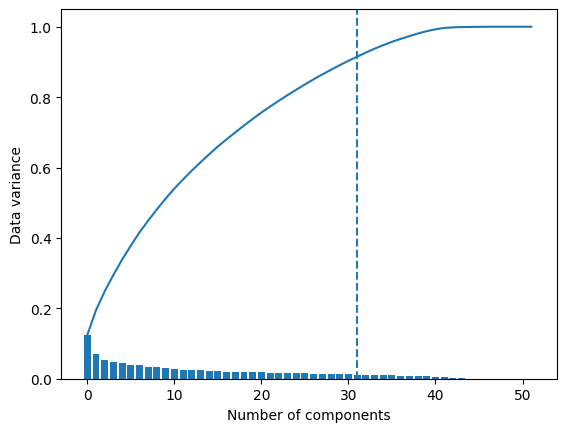

In [5]:
model.plot_cumulative_variance()
plt.gca().axvline(model.n,ls='--');

Testing the model (faulty period):

In [6]:
model.predict(df_test)

Looking at the test SPE chart:

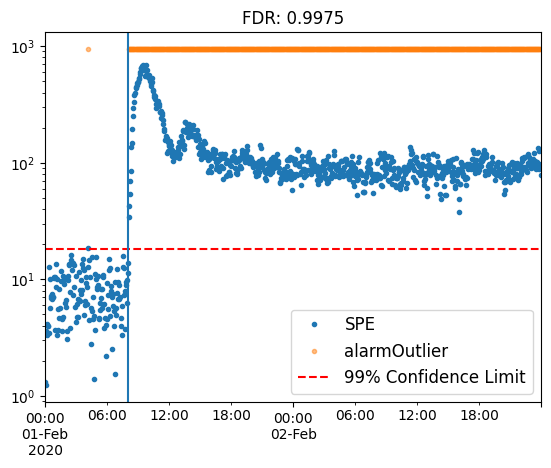

In [7]:
model.plot_SPE(train_or_test = 'test')
plt.gca().axvline(fault_start);
plt.title(f'FDR: {model.alarmOutlier[fault_start:].mean()}');

## Analyzing the effect of preprocessing techniques

In `BibMon`, applying preprocessing techniques is simple: just define lists with the names of the functions, in order of application, and supply them to the **fit** and **predict** methods.

At Tennessee Eastman, in particular, the IDV-11 case's fault detection rate benefits from applying noise filtering techniques and adding dynamics via lags.

In [8]:
# importando dados
df_train, df_test = bibmon.load_tennessee_eastman(train_id = 0, test_id = 11)

* Using the default pre-processing pipeline:

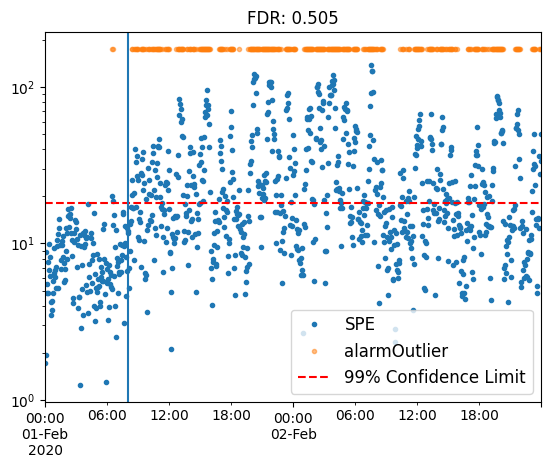

In [9]:
model = bibmon.PCA()

model.fit(df_train, redefine_limit = True, frac_val = 0.1)

model.predict(df_test)

model.plot_SPE(train_or_test = 'test')
plt.gca().axvline(fault_start);
plt.title(f'FDR: {model.alarmOutlier[fault_start:].mean()}');

* Applying lag:

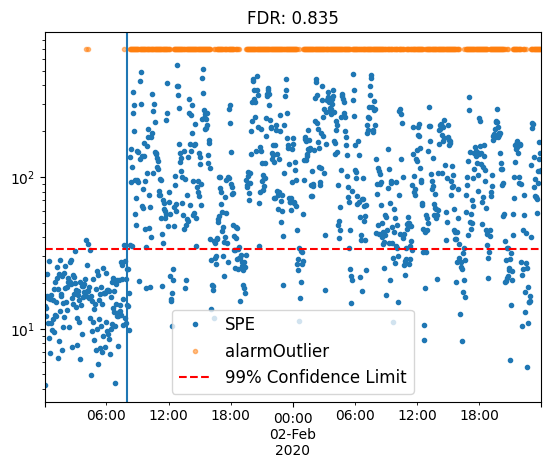

In [10]:
model = bibmon.PCA()

preproc = ['apply_lag', 'normalize']

model.fit(df_train, f_pp = preproc, f_pp_test = preproc, redefine_limit = True, frac_val = 0.1)

model.predict(df_test)

model.plot_SPE(train_or_test = 'test')
plt.gca().axvline(fault_start);
plt.title(f'FDR: {model.alarmOutlier[fault_start:].mean()}');

* Applying a moving average filter:

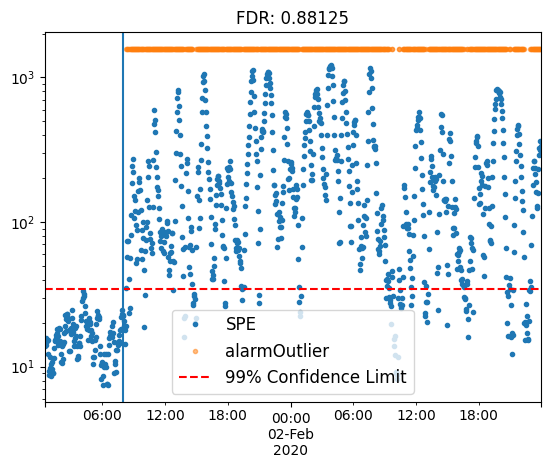

In [11]:
model = bibmon.PCA()

preproc = ['moving_average_filter', 'normalize']

model.fit(df_train, f_pp = preproc, f_pp_test = preproc, redefine_limit = True, frac_val = 0.1)

model.predict(df_test)

model.plot_SPE(train_or_test = 'test')
plt.gca().axvline(fault_start);
plt.title(f'FDR: {model.alarmOutlier[fault_start:].mean()}');

* Applying filter and lag, modifying parameters using the **args_preproc** argument:

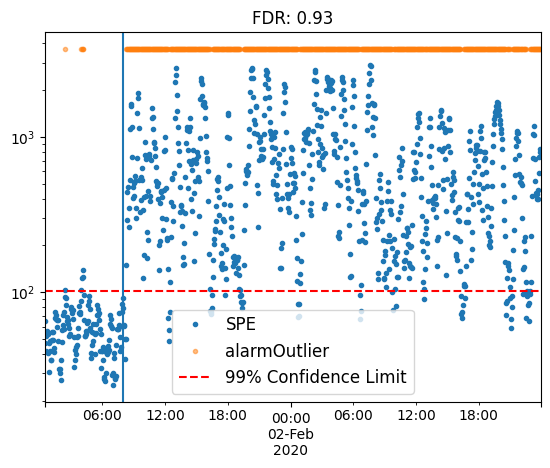

In [12]:
model = bibmon.PCA()

preproc = ['apply_lag', 'moving_average_filter', 'normalize']
args_preproc = {'moving_average_filter__WS': 5, 'apply_lag__lag': 5}

model.fit(df_train, f_pp = preproc, a_pp = args_preproc,
          f_pp_test = preproc, a_pp_test = args_preproc,
          redefine_limit = True, frac_val = 0.1)

model.predict(df_test)

model.plot_SPE(train_or_test = 'test')
plt.gca().axvline(fault_start);
plt.title(f'FDR: {model.alarmOutlier[fault_start:].mean()}');